<a href="https://colab.research.google.com/github/RheyMartt/CCMACLRL_EXERCISE_COM222ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os, types

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [373]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [374]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [375]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [376]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [377]:
df = df_train
df.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [379]:
df.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [380]:
df.duplicated().sum()

0

5. Check how many rows belong to each class

In [381]:
df = df_train
df['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [382]:
df_train = df_train.drop_duplicates()

7. Remove rows with NaN values

In [383]:
df_train = df_train.dropna()

8. Convert all text to lowercase

In [384]:
df_train['text'] = df_train['text'].str.lower()

9. Remove digits, URLS and special characters

In [385]:
df_train['text'] = df_train['text'].str.replace(r'http\S+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r'[^\w\s]', '', regex=True)

10. Remove stop words

In [386]:
# prompt: add more filipino words

stop_words = set(stopwords.words('english'))
filipino_stop_words = [
    "ako", "ang", "mga", "si", "ni", "kay", "sa", "ng", "at", "ay", "ito",
    "iyan", "iyon", "siya", "kami", "tayo", "sila", "ikaw", "kayo", "akin",
    "amin", "inyo", "kanila", "lahat", "bawat", "dahil", "kung", "ngunit",
    "o", "para", "nasa", "mula", "hanggang", "doon", "dito", "ngayon",
    "noon", "pagkatapos", "bago", "habang", "kahit", "hindi", "wala",
    "may", "mayroon", "pa", "rin", "din", "kasi", "lamang","ikaw","ka"
]
stop_words.update(filipino_stop_words)

def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  return " ".join(filtered_sentence)

df_train['text'] = df_train['text'].apply(remove_stopwords)


11. Use Stemming or Lemmatization

In [387]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

df_train['text'] = df_train['text'].apply(remove_stopwords)

stemmer = PorterStemmer()
def stem_words(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

df_train['text'] = df_train['text'].apply(stem_words)

## C. Training your model

12. Put all text training data in variable **X_train**

In [388]:
X_train = df_train['text']
X_train

,text
0,presidenti candid mar roxa impli govt liabl la...
1,parang mali na sumunod patalasta nescaf coffe ...
2,bet ko pula kulay posa
3,usernam kakampink
4,bakit parang tahimik pink doc willi ong reacti...
...,...
21768,marco talunan marco magnanakaw
21769,grabe binay
21770,usernam cnu ba naman hindimabibighani iyo maam...
21771,rt usernam tabi tabi yung nagsasab parang tang...


13. Put all training data labels in variable **y_train**

In [389]:
y_train = df_train['label']
y_train

,label
0,1
1,1
2,1
3,0
4,1
...,...
21768,1
21769,0
21770,0
21771,1


14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [390]:
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


15. Create an instance of `MultinomalNB()`

In [391]:
model = MultinomialNB(alpha=0.5)

16. Train the model using `.fit()`

In [392]:
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=0.5)

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [393]:
X_validation = df_validation['text']

X_validation = X_validation.str.lower()
X_validation = X_validation.str.replace(r'http\S+', '', regex=True)
X_validation = X_validation.str.replace(r'[^\w\s]', '', regex=True)
X_validation = X_validation.apply(remove_stopwords)
X_validation = X_validation.apply(stem_words)

X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [394]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_validation = df_validation['label']

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.8317857142857142
Precision: 0.8068920676202861
Recall: 0.8770318021201413
F1-Score: 0.8405011852353539


19. Create a confusion matrix using the **validation dataset**

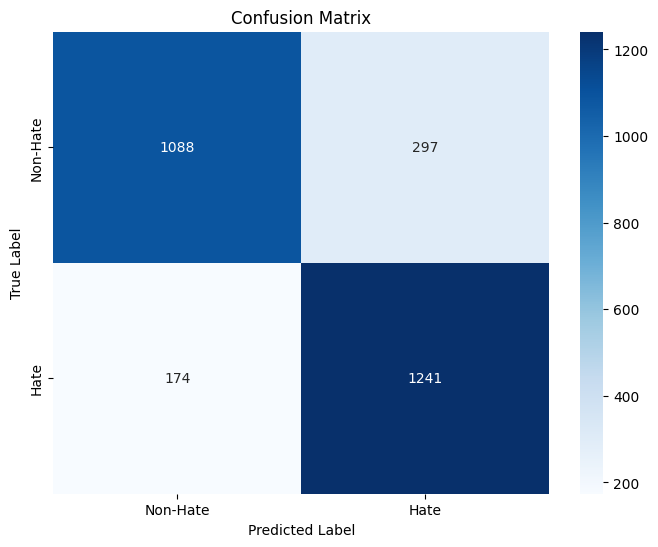

In [395]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_validation, y_validation_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [396]:
X_test = df_test['text']

X_test = X_test.str.lower()
X_test = X_test.str.replace(r'http\S+', '', regex=True)
X_test = X_test.str.replace(r'[^\w\s]', '', regex=True)
X_test = X_test.apply(remove_stopwords)
X_test = X_test.apply(stem_words)

X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [397]:
y_test = df_test['label']

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.8320284697508897
Precision: 0.8054089709762533
Recall: 0.8733905579399142
F1-Score: 0.8380233356211393


22. Create a confusion matrix using the **test dataset**

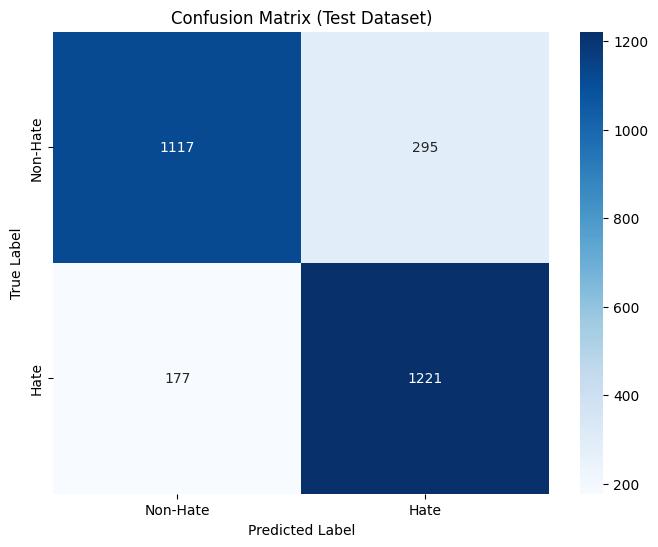

In [398]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Dataset)')
plt.show()


## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [406]:
def test_model(input_text):
  input_text = input_text.lower()
  input_text = re.sub(r'http\S+', '', input_text)
  input_text = re.sub(r'[^\w\s]', '', input_text)
  input_text = remove_stopwords(input_text)
  input_text = stem_words(input_text)

  input_text_transformed = vectorizer.transform([input_text])
  prediction = model.predict(input_text_transformed)[0]
  print(prediction)

  if prediction == 0:
    print("non-hate")
  else:
    print("hate")

24. Test the model by providing a hate speech input. The model should predict it as 1

In [407]:
test_model("Magandang umaga sainyong lahat!")

0
non-hate


In [409]:
test_model("Ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putang ina")

1
hate
